In [1]:
import numpy as np 
import pandas as pd 
import os
from zipfile import ZipFile
data_path = 'archive (24).zip'
with ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('Chest-ctscan-images')
print('The data set has been extracted.')
for dirname, _, filenames in os.walk("chest-ctscan-images"):
    print(f"Scanning directory: {dirname}")  
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        if not os.path.exists(full_path):
            print(f"Warning: Missing file {full_path}")

The data set has been extracted.
Scanning directory: chest-ctscan-images
Scanning directory: chest-ctscan-images\Data
Scanning directory: chest-ctscan-images\Data\test
Scanning directory: chest-ctscan-images\Data\test\adenocarcinoma
Scanning directory: chest-ctscan-images\Data\test\large.cell.carcinoma
Scanning directory: chest-ctscan-images\Data\test\normal
Scanning directory: chest-ctscan-images\Data\test\squamous.cell.carcinoma
Scanning directory: chest-ctscan-images\Data\train
Scanning directory: chest-ctscan-images\Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Scanning directory: chest-ctscan-images\Data\train\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
Scanning directory: chest-ctscan-images\Data\train\normal
Scanning directory: chest-ctscan-images\Data\train\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
Scanning directory: chest-ctscan-images\Data\valid
Scanning directory: chest-ctscan-images\Data\valid\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Scanning directory: 

In [3]:
TRAINING_EPOCHS = 120
BATCH_SIZE = 32
image_height = 350
image_width = 350

In [5]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [7]:
gen = ImageDataGenerator(rescale = 1./255,
                         zoom_range = 0.05,
                         width_shift_range = 0.05,
                         height_shift_range = 0.05,
                         brightness_range = [0.95,1.05])
 
train_generator = gen.flow_from_directory(
    directory = "chest-ctscan-images/Data/train", 
    color_mode = "rgb",
    target_size = (image_height, image_width), 
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 613 images belonging to 4 classes.


In [9]:
gen = ImageDataGenerator(rescale = 1./255,
                         zoom_range = 0.05,
                         width_shift_range = 0.05,
                         height_shift_range = 0.05,
                         brightness_range = [0.95,1.05])
 
train_generator = gen.flow_from_directory(
    directory = "chest-ctscan-images/Data/train", 
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 613 images belonging to 4 classes.


In [57]:
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_directory(
    directory   = "chest-ctscan-images/Data/valid",
    color_mode  = "rgb",
    target_size = (image_height, image_width), 
    class_mode  = "categorical",
    batch_size  = 5,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_directory(
    directory   = "chest-ctscan-images/Data/test", 
    color_mode  = "rgb",
    target_size = (image_height, image_width), 
    class_mode  = "categorical", 
    batch_size  = BATCH_SIZE, 
    shuffle     = False,
    seed        = 42
)


Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [11]:
a = train_generator.class_indices
class_names = list(a.keys()) 

In [13]:
nouveaux_noms = ["adenocarcinoma", "large.cell.carcinoma", "normal", "squamous.cell.carcinoma"]
class_names = nouveaux_noms

In [15]:
class_names

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [17]:
freq = np.unique(train_generator.classes, return_counts=True)

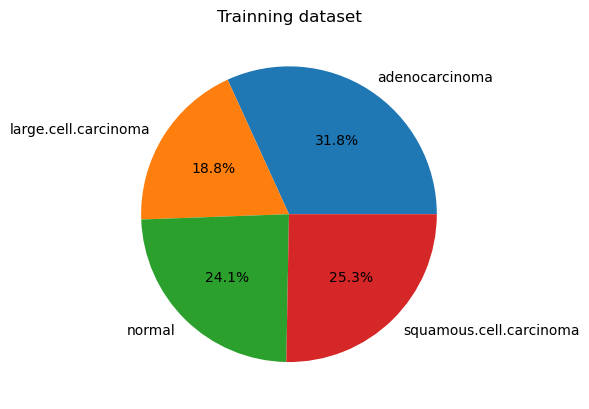

In [19]:
plt.title("Trainning dataset")
plt.pie(freq[1], labels = class_names, autopct='%1.1f%%');

In [23]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))  

In [27]:
class_weights

{0: 0.7858974358974359,
 1: 1.3326086956521739,
 2: 1.035472972972973,
 3: 0.9887096774193549}

In [25]:
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])])    

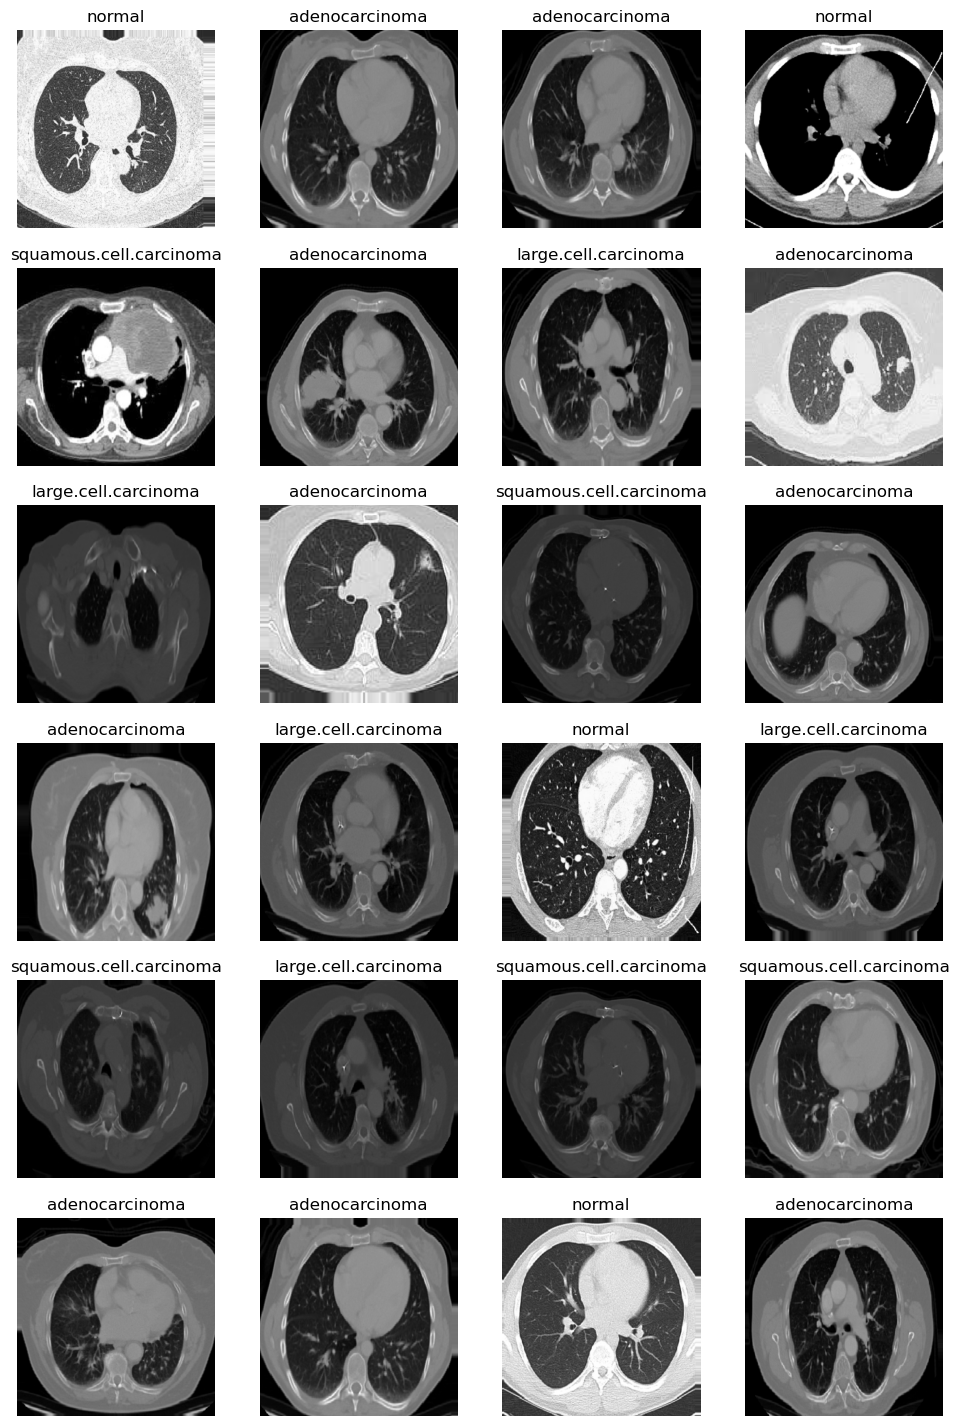

In [29]:
x,y = next(train_generator)
plot_images(x,y)

In [31]:
import numpy as np
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy\nFinal Training Accuracy: {acc[-1]:.3f}\nFinal Validation Accuracy: {val_acc[-1]:.3f}')
    plt.xlabel('Epochs')  
    plt.grid(True)

    plt.yticks(np.arange(0, 1.01, 0.2))  
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])    
    new_title = f'{title}\n Sensitivity = {sensitivity:.2f} Specificity = {specificity:.2f}'    
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)    
    ax.set_title(new_title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

In [35]:
from matplotlib import cm
import tensorflow as tf
import numpy as np

def make_gradcam_heatmap(image, model, last_conv_layer_name): 
    img_array = tf.expand_dims(image, axis=0)
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None
   
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

  
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()  
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255 
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    model.layers[-1].activation = last_layer_activation    
    return superimposed_img

In [37]:
from matplotlib import cm

def make_gradcam_plus_plus_heatmap(image, model, last_conv_layer_name):
    img_array = tf.expand_dims(image, axis=0)
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    guided_grads_pos = tf.cast(last_conv_layer_output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    guided_grads_neg = tf.cast(last_conv_layer_output < 0, 'float32') * tf.cast(grads < 0, 'float32') * grads
    guided_grads = guided_grads_pos + guided_grads_neg
    pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    gradcam_plus_plus_heatmap = last_conv_layer_output @ pooled_guided_grads[..., tf.newaxis]
    gradcam_plus_plus_heatmap = tf.squeeze(gradcam_plus_plus_heatmap)
    gradcam_plus_plus_heatmap = tf.maximum(gradcam_plus_plus_heatmap, 0) / tf.reduce_max(gradcam_plus_plus_heatmap)
    gradcam_plus_plus_heatmap = gradcam_plus_plus_heatmap.numpy()
    gradcam_plus_plus_heatmap = np.uint8(255 * gradcam_plus_plus_heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    gradcam_plus_plus_jet_heatmap = jet_colors[gradcam_plus_plus_heatmap]
    gradcam_plus_plus_jet_heatmap = tf.keras.utils.array_to_img(gradcam_plus_plus_jet_heatmap)
    gradcam_plus_plus_jet_heatmap = gradcam_plus_plus_jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    gradcam_plus_plus_jet_heatmap = tf.keras.utils.img_to_array(gradcam_plus_plus_jet_heatmap)
    gradcam_plus_plus_superimposed_img = gradcam_plus_plus_jet_heatmap * 0.4 + img_array[0] * 255 
    gradcam_plus_plus_superimposed_img = tf.keras.utils.array_to_img(gradcam_plus_plus_superimposed_img)
    model.layers[-1].activation = last_layer_activation    
    return gradcam_plus_plus_superimposed_img

In [35]:
from tensorflow.keras.optimizers import Adamax

def create_model(base_model, NUM_CLASSES):
    x = base_model.output
    x = Flatten()(x)    
    x = Dense(1024, activation='relu')(x)    
    x = Dropout(0.25)(x)    
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)    
    predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)    
    model.layers[0].trainable = False
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adamax(), 
        metrics=['accuracy'])
    return model

In [41]:
from tensorflow.keras.optimizers import Adamax

def fit_model(model, base_model, epochs, fine_tune=0,initial_epoch=0):
    print("Unfreezing number of layers in base model =", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        model.compile(optimizer=Adamax(1e-5), 
                      loss='categorical_crossentropy',  
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=Adamax(), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
       
    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=epochs,
                        initial_epoch=initial_epoch)    
    return history

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def create_model(base_model, num_classes):
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

DenseNet169_custom_model = create_model(DenseNet169, 4) 
from tensorflow.keras.optimizers import Adam
DenseNet169_custom_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy", 
    metrics=["accuracy"])

In [67]:
loss, accuracy = DenseNet169_custom_model.evaluate(test_generator)
history = DenseNet169_custom_model.fit(train_generator, epochs=TRAINING_EPOCHS, validation_data=validation_generator)
print("Loss: {:.3f}".format(loss))
print("Accuracy: {:.2f}%".format(accuracy * 100))

10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.1218 - loss: 2.2684
Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.3830 - loss: 1.3750 - val_accuracy: 0.5833 - val_loss: 0.8753
Epoch 2/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - accuracy: 0.6817 - loss: 0.8096 - val_accuracy: 0.5000 - val_loss: 0.9589
Epoch 3/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.7060 - loss: 0.7084 - val_accuracy: 0.5278 - val_loss: 0.9776
Epoch 4/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.6889 - loss: 0.6571 - val_accuracy: 0.5833 - val_loss: 0.8450
Epoch 5/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.8224 - loss: 0.5039 - val_accuracy: 0.6944 - val_loss: 0.7245
Epoch 6/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step - accuracy: 0.7853 - loss: 0.5200 - val_accuracy: 0.7083 - val_loss: 0.6709
Epoch 7/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.8591 - loss: 0.4207 - val_accuracy: 0.6667 - val_loss: 0.7276
Epoch 8/120
20/20 ━━━━━━━━━━━━━

In [77]:
test_generator.reset()
DenseNet169_test_preds = DenseNet169_custom_model.predict(test_generator)
DenseNet169_test_pred_classes = np.argmax(DenseNet169_test_preds, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step


In [79]:
DenseNet169_test_pred_classes

array([0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 3, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3,
       3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [81]:
vgg19_base_model = tf.keras.applications.vgg19.VGG19(
                             include_top=False,
                             weights='imagenet',
                             input_shape=(image_height, image_width, 3)
                             
vgg19_model = create_model(vgg19_base_model, 4)
history = fit_model(vgg19_model, vgg19_base_model, epochs=TRAINING_EPOCHS)

Unfreezing number of layers in base model = 0
Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 231s 10s/step - accuracy: 0.2984 - loss: 1.4036 - val_accuracy: 0.4861 - val_loss: 1.2583
Epoch 2/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - accuracy: 0.4771 - loss: 1.2018 - val_accuracy: 0.4583 - val_loss: 1.1983
Epoch 3/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.5868 - loss: 1.1246 - val_accuracy: 0.4306 - val_loss: 1.1614
Epoch 4/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 194s 10s/step - accuracy: 0.5769 - loss: 1.0789 - val_accuracy: 0.4722 - val_loss: 1.1273
Epoch 5/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - accuracy: 0.6050 - loss: 1.0311 - val_accuracy: 0.4583 - val_loss: 1.0860
Epoch 6/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.5710 - loss: 1.0256 - val_accuracy: 0.4722 - val_loss: 1.0796
Epoch 7/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.5888 - loss: 0.9799 - val_accuracy: 0.4722 - val_loss: 1.0458
Epoch 8/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 161s 8s/step - a

In [83]:
accuracy_score_vgg19 = vgg19_model.evaluate(test_generator)
print(accuracy_score_vgg19)
print("Accuracy: {:.2f}%".format(accuracy_score_vgg19[1] * 100))
print("Loss: {:.3f}".format(accuracy_score_vgg19[0]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 10s/step - accuracy: 0.7844 - loss: 0.6227
[0.7003106474876404, 0.7079365253448486]
Accuracy: 70.79%
Loss: 0.700


In [85]:
test_generator.reset()
vgg19_test_preds = vgg19_model.predict(test_generator)
vgg19_test_pred_classes = np.argmax(vgg19_test_preds, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step


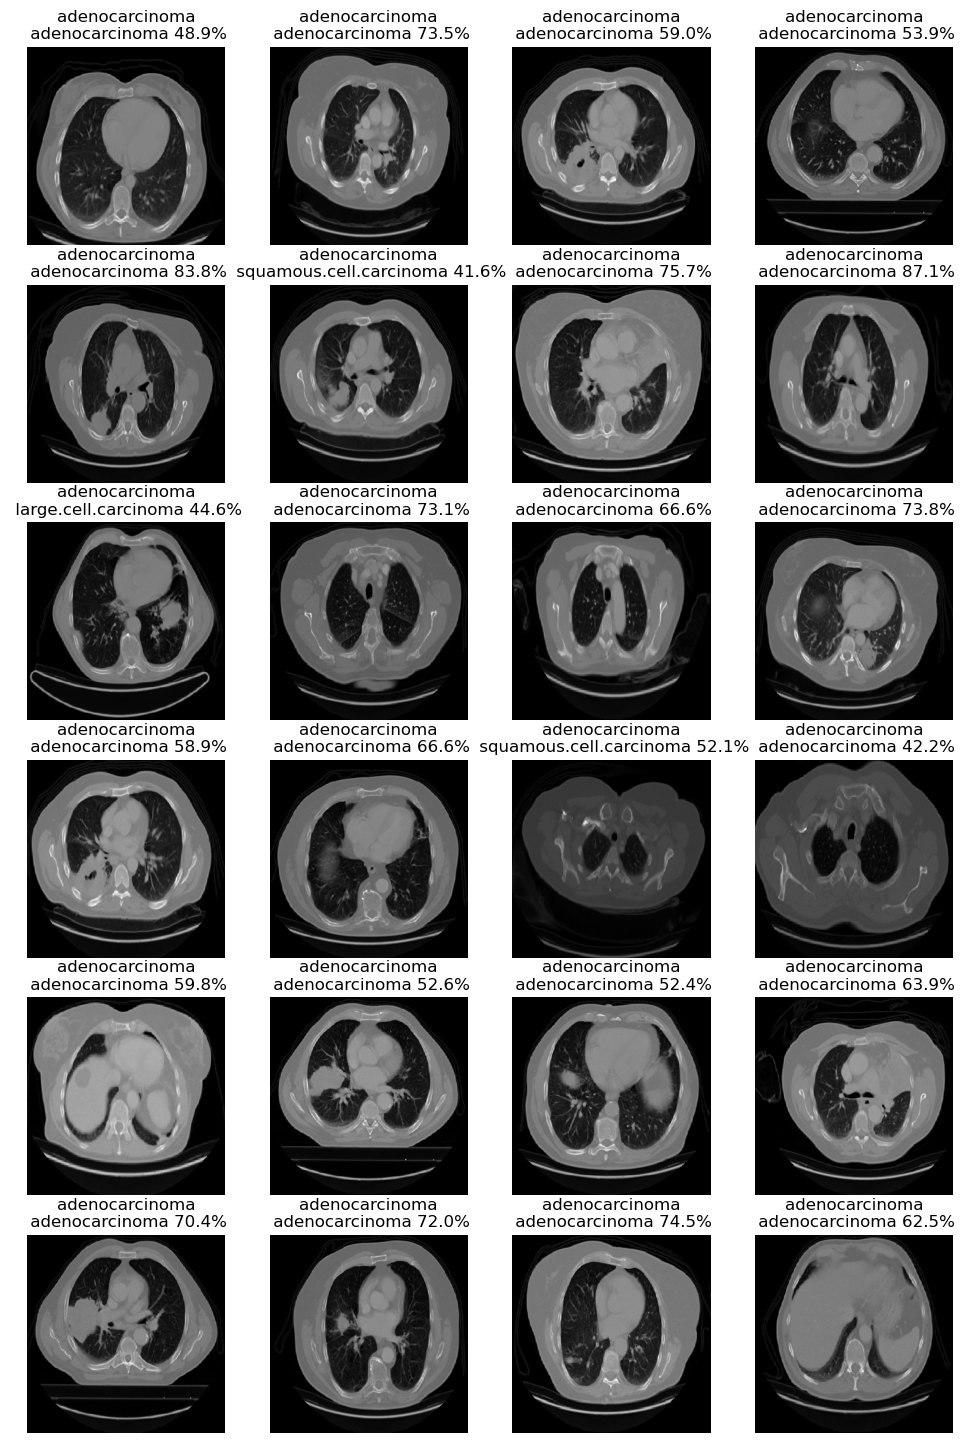

In [87]:
test_generator.reset()
x, y = next(test_generator)
plot_images(x, y, vgg19_test_preds)

D:\Anaconda\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_629']]
Received: inputs=Tensor(shape=(1, 350, 350, 3))
  warnings.warn(msg)
C:\Users\user\AppData\Local\Temp\ipykernel_29260\1407156733.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


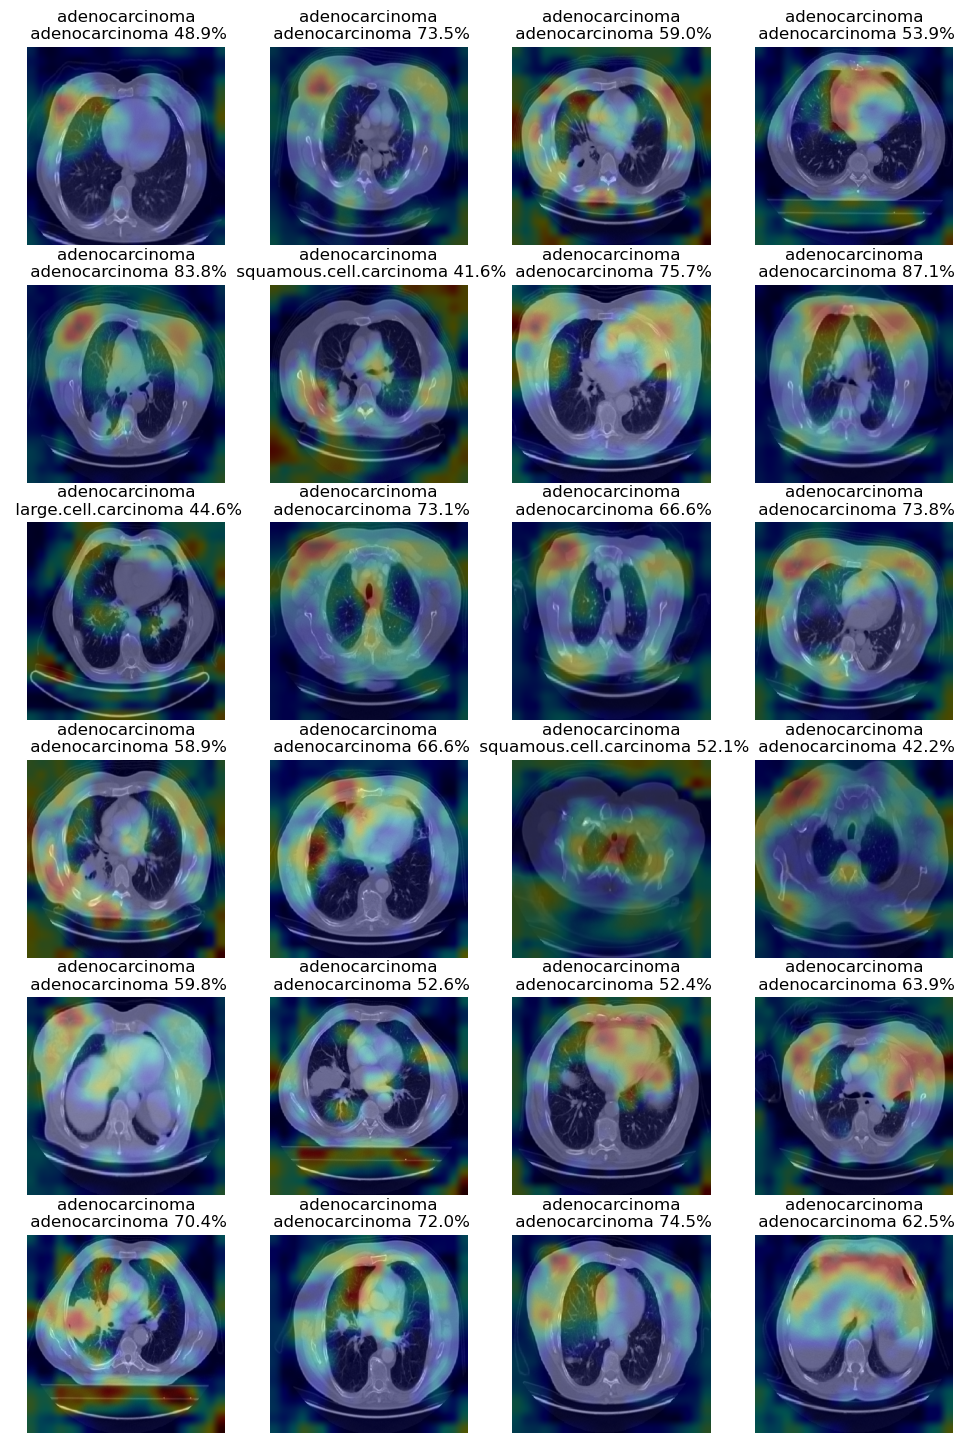

In [89]:
last_conv_layer_name = "block5_conv4"

heatmaps =[]

for img in x:
    heatmap = make_gradcam_heatmap(img, vgg19_model, last_conv_layer_name)
    heatmaps.append(heatmap)
    
plot_images(heatmaps, y, vgg19_test_preds)

In [91]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model,4)
#inception_model.summary()
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 92s 0us/step
Unfreezing number of layers in base model = 0
Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 156s 7s/step - accuracy: 0.4246 - loss: 1.2838 - val_accuracy: 0.5278 - val_loss: 0.9922
Epoch 2/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 120s 6s/step - accuracy: 0.6551 - loss: 0.8701 - val_accuracy: 0.5833 - val_loss: 0.9120
Epoch 3/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.6358 - loss: 0.8138 - val_accuracy: 0.5139 - val_loss: 0.9309
Epoch 4/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - accuracy: 0.6898 - loss: 0.7276 - val_accuracy: 0.5694 - val_loss: 0.8677
Epoch 5/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - accuracy: 0.7437 - loss: 0.6580 - val_accuracy: 0.5694 - val_loss: 0.9248
Epoch 6/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.7272 - loss: 0.6768 - val_accuracy: 0.5556 - val_loss: 0.8935
Epoch 7/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.6856 - loss: 0.6868 - val_accuracy: 0.5833 - val_loss: 0.8751
Epo

In [93]:
accuracy_score = inception_model.evaluate(test_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.5988 - loss: 1.1522
[0.740127682685852, 0.7492063641548157]
Accuracy: 74.92%
Loss: 0.740
